In [1]:
%matplotlib widget

In [2]:
# initialization
from rayoptics.environment import *

from rayoptics.gui import dashboards
import ipywidgets as widgets

In [3]:
isdark = False
nbdpi = 150

# Create a new model

In [4]:
opm = OpticalModel()
sm  = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']
em = opm['ele_model']
pt = opm['part_tree']
ar = opm['analysis_results']

### Define first order aperture and field for system

In [5]:
osp['pupil'] = PupilSpec(osp, key=['object', 'pupil'], value=12.5)

osp['fov'] = FieldSpec(osp, key=['object', 'angle'], value=20.0, flds=[0., 0.707, 1.], is_relative=True)

osp['wvls'] = WvlSpec([('F', 0.5), ('d', 1.0), ('C', 0.5)], ref_wl=1)

### Define interface and gap data for the sequential model

In [6]:
opm.radius_mode = True

sm.gaps[0].thi=1e10

sm.add_surface([23.713, 4.831, 'N-LAK9', 'Schott'])
sm.add_surface([7331.288, 5.86])
sm.add_surface([-24.456, .975, 'N-SF5,Schott'])
sm.set_stop()
sm.add_surface([21.896, 4.822])
sm.add_surface([86.759, 3.127, 'N-LAK9', 'Schott'])
sm.add_surface([-20.4942, 41.2365-.11])

### Update the model

In [7]:
opm.update_model()

## List the optical specifications

In [8]:
pm.first_order_data()

efl                  50
ffl               -37.1
pp1                12.9
bfl               41.24
ppk               8.763
f/#                   4
m                -5e-09
red              -2e+08
obj_dist          1e+10
obj_ang              20
enp_dist          11.68
enp_radius         6.25
na obj         6.25e-10
n obj                 1
img_dist          41.24
img_ht             18.2
exp_dist         -9.902
exp_radius        6.406
na img           -0.124
n img                 1
optical invariant        2.275


# Draw a lens picture

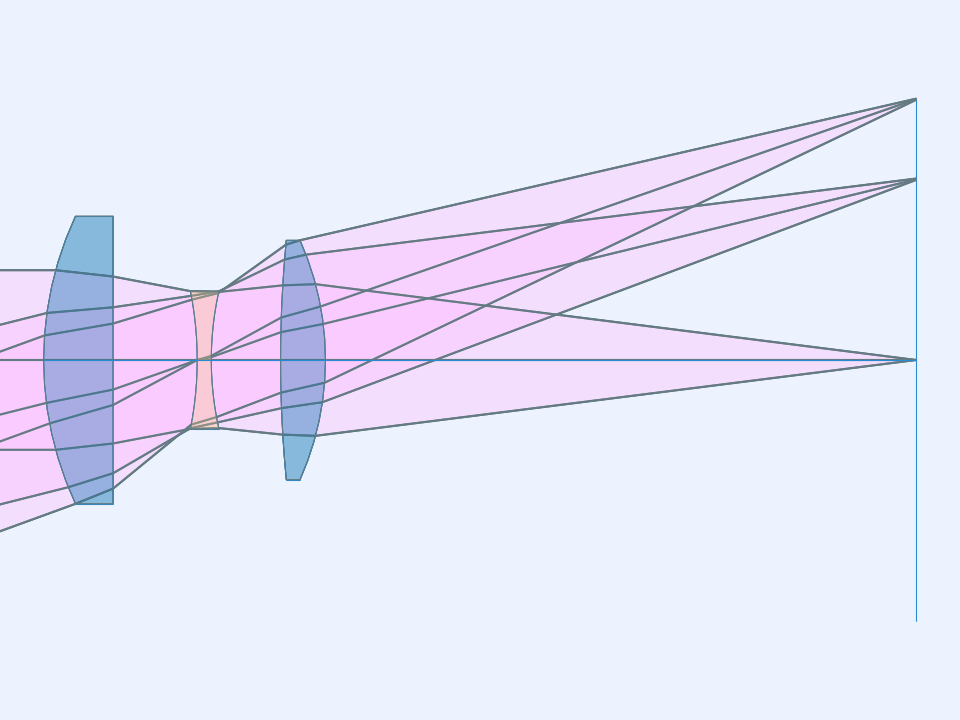

In [9]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm,
                        do_draw_beams=True,
                        do_draw_ray_fans=False,
                        do_paraxial_layout=False,
                        dpi=nbdpi, is_dark=isdark).plot()

## Plot the transverse ray aberrations

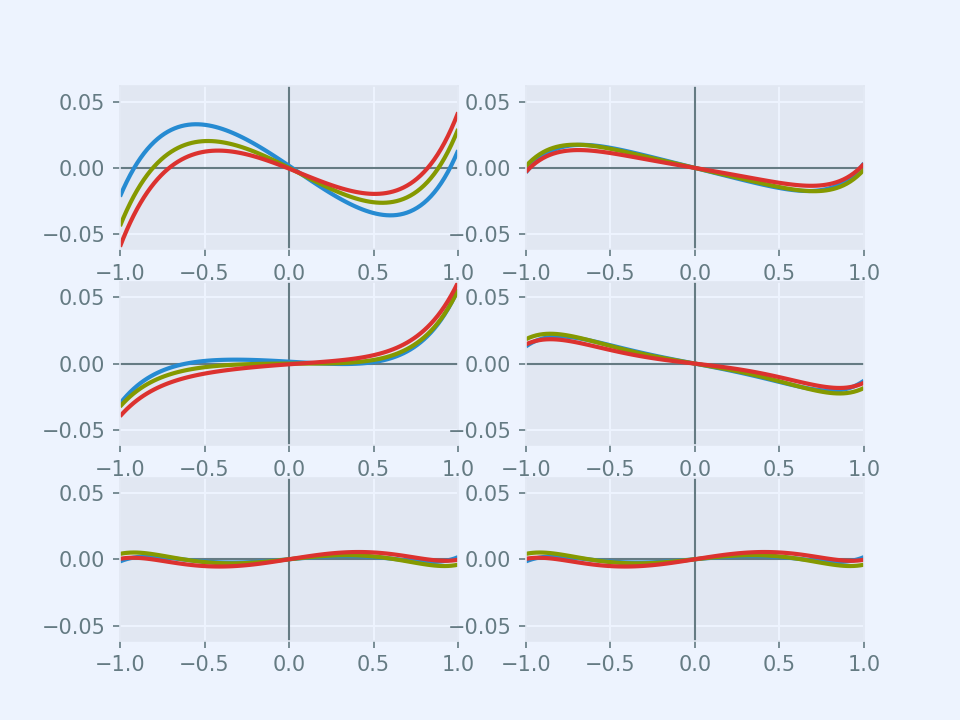

In [10]:
abr_plt = plt.figure(FigureClass=RayFanFigure, opt_model=opm,
                     data_type='Ray',
                     scale_type=Fit.All_Same,
                     dpi=nbdpi, is_dark=isdark).plot()

## Plot the wavefront aberration

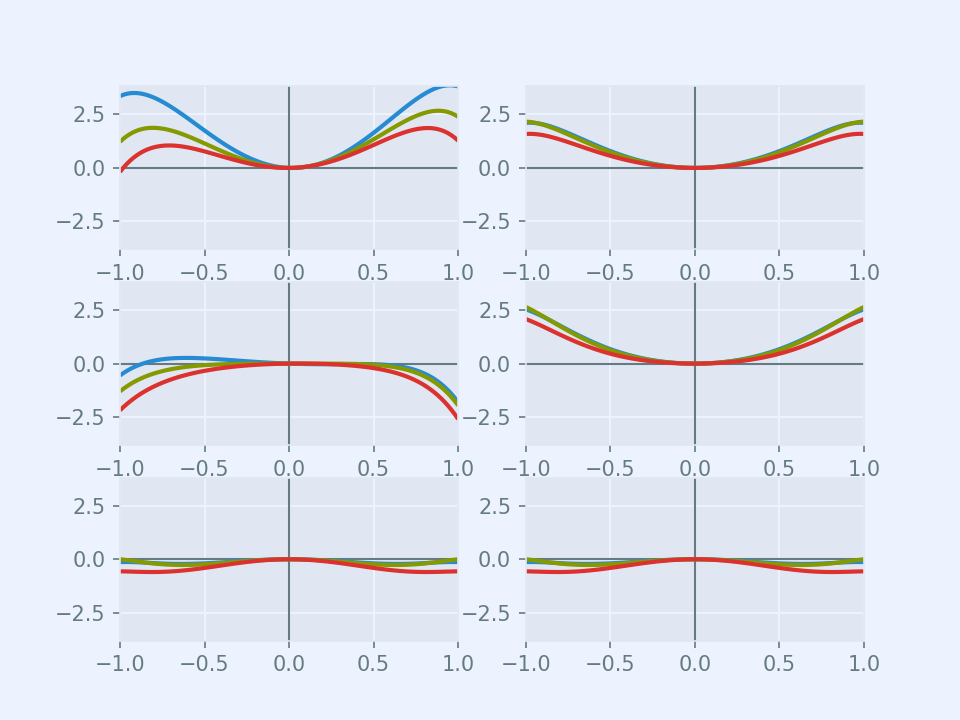

In [11]:
wav_plt = plt.figure(FigureClass=RayFanFigure, opt_model=opm,
                     data_type='OPD',
                     scale_type=Fit.All_Same,
                     dpi=nbdpi, is_dark=isdark).plot()

# Create Aberration Dashboard
### select field 0, the axial field

In [12]:
fld, wvl, foc = osp.lookup_fld_wvl_focus(0)

### create fan and grid objects for use by plot grid

In [13]:
ray_xfan = analyses.RayFan(opm, f=fld, wl=wvl, xyfan='x')
ray_yfan = analyses.RayFan(opm, f=fld, wl=wvl, xyfan='y')
ray_grid = analyses.RayGrid(opm, f=fld, wl=wvl)

### Create lists of fans, data types, and plotting keyword arguments to drive 

In [14]:
xyabr_fan_list = [(ray_xfan, 'dx', dict(num_points=100)),
                  (ray_yfan, 'dy', dict(num_points=100, linestyle='--'))]

In [15]:
opd_fan_list = [(ray_yfan, 'opd', dict(linestyle='', linewidth=1, marker='D', markersize=3.5)),
                (ray_yfan, 'opd', dict(num_points=100, linewidth=2))]

### create focus dashboard

In [16]:
fod = ar['parax_data'].fod
one_wave = opm.nm_to_sys_units(wvl)
# one wave of defocus
dfoc = one_wave/(fod.img_na**2/(2*fod.n_img))
qwrt_dfoc = abs(0.25*dfoc)

# one wave of tilt
_, _, ref_sphere_radius = fld.ref_sphere
shft = ref_sphere_radius*one_wave/fod.exp_radius

In [17]:
opd_scale = 1.
ta_scale = .05

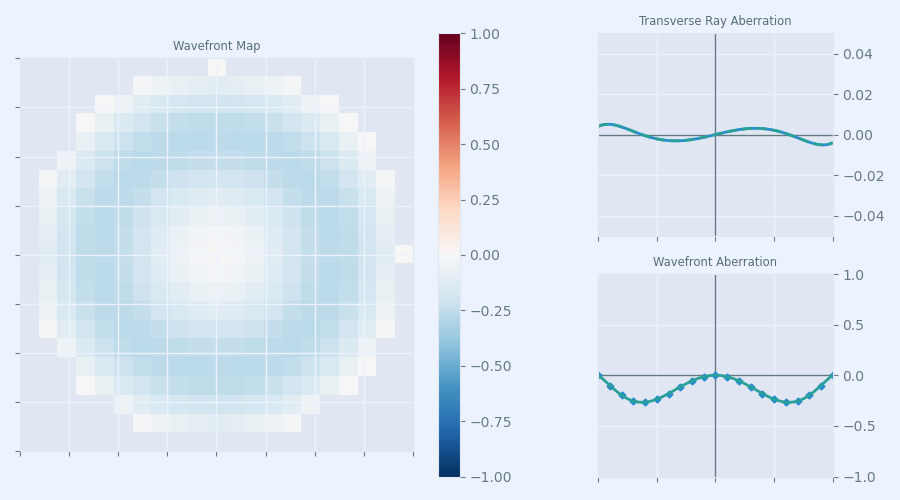

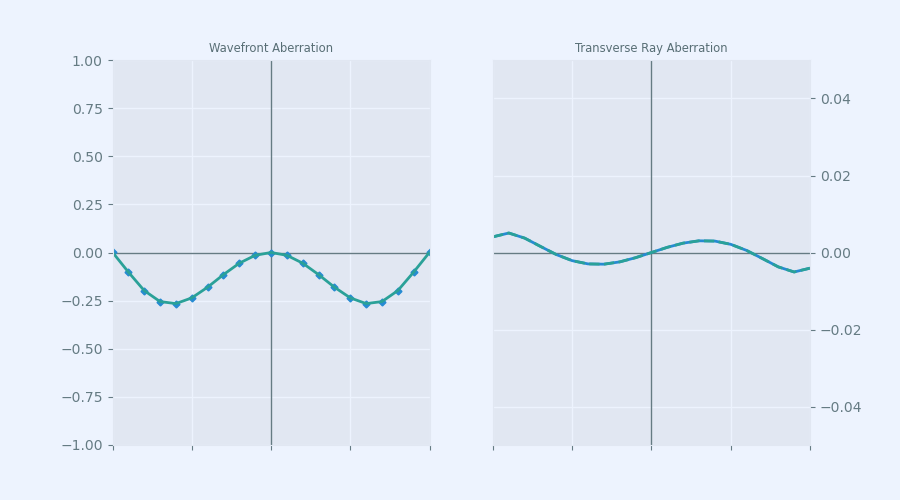

In [18]:
# create a figure with a wavefront map and transverse ray and opd ray fans
wfr = Wavefront(ray_grid, user_scale_value=opd_scale, do_contours=False, title='Wavefront Map')
xy_fan = RayFanPlot(xyabr_fan_list, user_scale_value=ta_scale, scale_type='user',
                    yaxis_ticks_position='right', title='Transverse Ray Aberration')
opd_fan = RayFanPlot(opd_fan_list, user_scale_value=opd_scale, scale_type='user',
                     yaxis_ticks_position='right', title='Wavefront Aberration')

fig = plt.figure(FigureClass=AnalysisFigure, data_objs=[ray_grid, ray_xfan, ray_yfan], subplots=[wfr, xy_fan, opd_fan],
                 grid=(8, 13), figsize=[9, 5], tight_layout=True, is_dark=isdark)
fig.gridspecs = [fig.gs[:8, :8], fig.gs[:4, 9:], fig.gs[4:8, 9:]]

fig.refresh()

# create a figure with transverse ray and opd ray fans 
tabr = RayFanPlot(xyabr_fan_list, user_scale_value=ta_scale, scale_type='user',
                  yaxis_ticks_position='right', title='Transverse Ray Aberration')
wabr = RayFanPlot(opd_fan_list, user_scale_value=opd_scale, scale_type='user',
                  yaxis_ticks_position='left', title='Wavefront Aberration')
fig2 = plt.figure(FigureClass=AnalysisFigure, data_objs=[ray_xfan, ray_yfan], subplots=[wabr, tabr],
                 grid=(1, 2), figsize=[9, 5], is_dark=isdark)

fig2.plot()

# create sliders for controlling defocus and image offset
defocus, x_shift, y_shift = dashboards.create_focus_dashboard([fig, fig2],
                                                   [ray_grid, ray_xfan, ray_yfan],
                                                   osp.defocus.focus_shift, abs(2*dfoc), shft, on_axis_pt=[0, 0])
display(widgets.HBox([defocus, y_shift]))